# 13.5 2012 Federal Election Commission Database

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The US Federal Election Commission (FEC) publishes data on contributions to polit‐
ical campaigns. This includes contributor names, occupation and employer, address,
and contribution amount. The contribution data from the 2012 US presidential
election was available as a single 150-megabyte CSV file P00000001-ALL.csv (see the
book’s data repository), which can be loaded with pandas.read_csv:

In [49]:
fec = pd.read_csv("P00000001-ALL.csv", low_memory=False)
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

Several people asked me to update the dataset from the 2012
election to the 2016 or 2020 elections. Unfortunately, the more
recent datasets provided by the FEC have become larger and more
complex, and I decided that working with them here would be a
distraction from the analysis techniques that I wanted to illustrate.

In [50]:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                        50.0
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

You may think of some ways to start slicing and dicing this data to extract informative
statistics about donors and patterns in the campaign contributions. I’ll show you a
number of different analyses that apply the techniques in this book.
You can see that there are no political party affiliations in the data, so this would be
useful to add. You can get a list of all the unique political candidates using unique:

In [51]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [52]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [53]:
fec["cand_nm"][123456:123461]
fec["cand_nm"][123456:123461].map(parties)
# Add it as a column
fec["party"] = fec["cand_nm"].map(parties)
fec["party"].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

In [54]:
(fec["contb_receipt_amt"] > 0).value_counts()

contb_receipt_amt
True     991475
False     10256
Name: count, dtype: int64

In [55]:
fec = fec[fec["contb_receipt_amt"] > 0]

In [56]:
fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

## Donation Statistics by Occupation and Employer

Donations by occupation is another oft-studied statistic. For example, attorneys tend
to donate more money to Democrats, while business executives tend to donate more
to Republicans. You have no reason to believe me; you can see for yourself in the
data. First, the total number of donations by occupation can be computed with
value_counts:

In [57]:
fec["contbr_occupation"].value_counts()[:10]

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: count, dtype: int64

You will notice by looking at the occupations that many refer to the same basic job
type, or there are several variants of the same thing. The following code snippet
illustrates a technique for cleaning up a few of them by mapping from one occupation
to another; note the “trick” of using dict.get to allow occupations with no mapping
to “pass through”:

In [58]:
occ_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "INFORMATION REQUESTED (BEST EFFORTS)" : "NOT PROVIDED",
   "C.E.O.": "CEO"
}

def get_occ(x):
    # If no mapping provided, return x
    return occ_mapping.get(x, x)

fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [59]:
emp_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "SELF" : "SELF-EMPLOYED",
   "SELF EMPLOYED" : "SELF-EMPLOYED",
}

def get_emp(x):
    # If no mapping provided, return x
    return emp_mapping.get(x, x)

fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

In [60]:
by_occupation = fec.pivot_table("contb_receipt_amt",
                                index="contbr_occupation",
                                columns="party", aggfunc="sum")
over_2mm = by_occupation[by_occupation.sum(axis="columns") > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


In [61]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='contbr_occupation'>

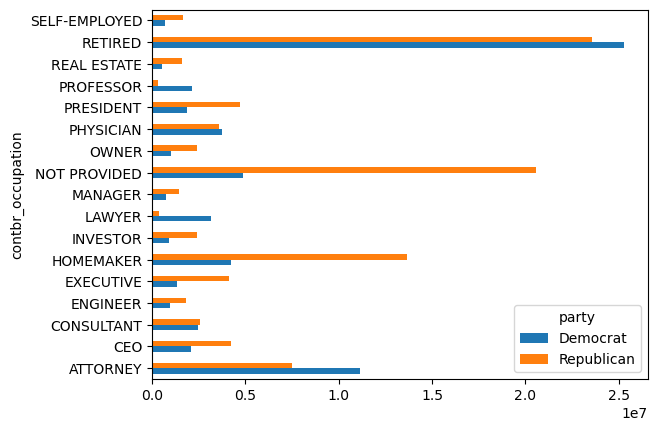

In [62]:
over_2mm.plot(kind="barh")

In [63]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

C:\Users\84909\AppData\Local\Temp\ipykernel_3340\3136066192.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_top_amounts, 'contbr_occupation', n=7)


cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [64]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

C:\Users\84909\AppData\Local\Temp\ipykernel_3340\1241302789.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_top_amounts, 'contbr_employer', n=10)


cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

## Bucketing Donation Amounts

In [65]:
bins = np.array([0, 1, 10, 100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [66]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

C:\Users\84909\AppData\Local\Temp\ipykernel_3340\2972708327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fec_mrbo.groupby(['cand_nm', labels])


cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


In [67]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,0.00
"(1000000, 10000000]",7148839.76,0.00


In [68]:
bucket_sums.sum(axis=1)

contb_receipt_amt
(0, 1]                 3.952400e+02
(1, 10]                3.670873e+05
(10, 100]              2.227677e+07
(100, 1000]            7.716191e+07
(1000, 10000]          1.156959e+08
(10000, 100000]        7.180000e+04
(100000, 1000000]      1.490683e+06
(1000000, 10000000]    7.148840e+06
dtype: float64

In [69]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<Axes: ylabel='contb_receipt_amt'>

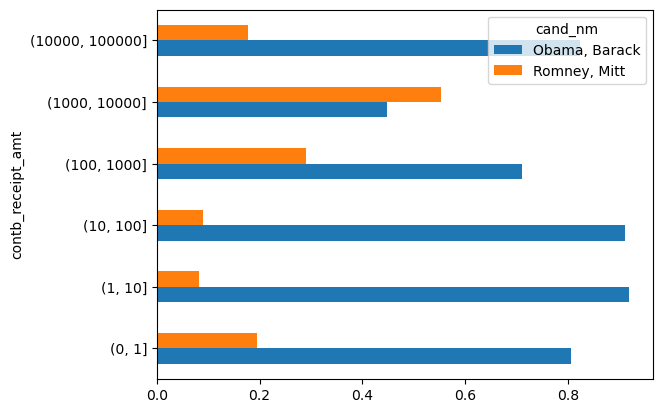

In [70]:
normed_sums[:-2].plot(kind='barh')

I excluded the two largest bins, as these are not donations by individuals.
This analysis can be refined and improved in many ways. For example, you could
aggregate donations by donor name and zip code to adjust for donors who gave many
small amounts versus one or more large donations. I encourage you to explore the
dataset yourself.

## Donation Statistics by State

In [71]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100_000]
totals.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [72]:
percent = totals.div(totals.sum(1), axis=0)
percent.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
